<a href="https://colab.research.google.com/github/gcorani/bda/blob/main/4_normal_hierarchical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
%matplotlib inline
import pymc as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
import random
random.seed(10)


In [36]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [8.0, 3.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0,
})

# Normal Hierarchical  Models

Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html


# Modeling songs popularity

* Spotify  provides a data bases of songs and their *popularity* score,  which varies over  the 0-100 scale.


* Higher popularity usually means the song has been played often, especially  recently.

# Research questions


*   What’s the typical popularity of a Spotify song?


*   How does popularity vary from artist to artist?


*   For any single artist, how much does popularity vary from song to song?


*  We look for answers with a quantification of the uncertainty.

# Hierarchical data set

* The data set  comprises  one or more songs for each of the 44 artists


* The list of artists  is a  sample from the whole population of  artists that have songs on Spotify

<div style="text-align: center;">
 <img src='https://drive.google.com/uc?export=view&id=1UdgWjLmXW_aO1p-Z5PLsGni7TL9_I-hv' width='700'>
</div>




# The structure of the data

* The $j$ subscript refers to the $j$-th  artist (we have 44 artists).

*  $n_j$: number of songs created by artist $j$.

*  $y_{ij}$:  popularity of the $i$-th song of artist $j$
    * $j \in \{1,2,…,44\}$, $i \in \{1,2,…,n_j\}$.

* The data set is constituted by  44 *sub-populations* (or *clusters*);   each artist provides a cluster of songs.

In [37]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song,
#author and popularity.
#The data set contains 350 songs by 44 artists
url = "https://raw.githubusercontent.com/gcorani/bda/refs/heads/main/nbooks/data/spotify.csv"
spotify = pd.read_csv(url)

#spotify = pd.read_csv("/content/spotify.csv")

spotify.head()

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52


In [38]:
# we create a list containing the  name of each artist: ['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé', ...]
spotify["artist"] = spotify["artist"].astype("category")
artists = list(spotify["artist"].cat.categories)

#show the first artists
artists[0:5]

['Alok', 'Atlas Genius', 'Au/Ra', 'BUNT.', 'Beyoncé']

# Mean popularity of each artist

In [39]:
# artist_popularity contains the mean popularity of the songs of each artist and the name of the artist
# artist ranked from the less popular one to the most popular one.
#we drop the title
spotify = spotify[ ["artist","popularity" ]]
artist_popularity=spotify.groupby(['artist'], observed=False).mean().sort_values('popularity').head();
artist_popularity

,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000


In [40]:
# Number of  songs of each artists.
artist_count=spotify.groupby(['artist'], observed=False).count()
artist_count.head()

,popularity
artist,
Alok,19
Atlas Genius,4
Au/Ra,5
BUNT.,3
Beyoncé,25


# Pooled and unpooled model

* *Pooled*: merge  data from songs of all artists, without modelling the difference between artists.
* Main problem: all artists are seen as equal.
     
### Unpooled model     
* Independently analyzes the songs of every  artist
* The mean popularity of songs from artist $j$ is $\mu_j$
* The posterior distribution of parameters of artists with published songs, due to few data, will have large uncertainty;
* Cannot predict the popularity of a new artist

# Hierarchical model (a.k.a. partial pooling)

* Artist $j$ has its own mean popularity of songs, $\mu_j$   
           
* $\mu_j$ is modelled as being drawn from the population of the mean popularity of the artists.

* The population of the $\mu_j$ artist is characterized by mean $\mu_p$ and std dev $\sigma_p$, where the subscript $p$ stands for *population* of artists.

* The 44 artists in our data set are a sample from the population of artists.
    
* We want to learn the characteristics of the population of artists.

* We thus treat $\mu_p$ and $\sigma_p$ as parameters to be learned from data, to which we  assign priors. Their posterior will be useful for making predictions about new artists, as we will see.







# Hierarchical model (partial pooling)

* It places a prior on the parameters of the prior (*hierarchical*).
    
       
* It can make prediction also for an artist for which there are no songs in our sample, based on what it has learned about the populations of artists. Moreover, it  improves the estimates for artists with few songs.






# Pooled model

<div style="text-align: center;">
 <img src='https://drive.google.com/uc?export=view&id=18ZXOpZ-nPKSYBz0rgsSxHNVI9dOQ7d6T' width='400'>
</div>


*  We fit a  normal-normal model  on all  songs in the sample (density  shown in the plot), ignoring the grouping structure implied by the different authors.


# Pooled model

* We fit a normal-normal model on  the data set containing all songs:

  
\begin{align*}
\mu & \sim N(\mu', \sigma' ) \\
\sigma & \sim \text{HalfNormal}(\xi)\\
\vec{y_{ij}} & \sim N(\mu, \sigma)
\end{align*}

*  $\mu$ and $\sigma$ are   *global* parameters, which apply to every song.

* $\mu'$ and  $\sigma'$ are fixed numbers which represent our prior beliefs in the plausible value of $\mu$ and our uncertainty about it.


# Prior on $\mu$

* A priori,  we assume $\mu$ to lie in  (30, 70).

* Interpreting the  interval as a region of $\pm$2 standard deviations, our prior beliefs about the mean of the population is:

$$ \mu \sim N(50, 10) $$



# Setting the prior on $\sigma$ via prior predictive check

* We adjust the scale of the halfnormal prior by generating virtual popularity values from the prior and comparing their range with the feasible range (0,100).

* Below we show how we find iteratively a sensible scale for the halfnormal.

In [41]:
from scipy.stats import norm, halfnorm

# mu_mean: mean of the prior on mu
# mu_std: std of the prior on mu
# hn_scale: scale of the hn prior on sigma
def sim_y_from_prior(mu_mean, mu_std, hn_scale):
  n = 10000
  #simulate mean from its prior
  mu_s = norm.rvs(loc = mu_mean, scale = mu_std, size = n)

  #simulate sigma from its prior
  s_s = halfnorm.rvs(scale = hn_scale, size = n)

  #simulate virtual popularity score
  y_s = norm.rvs(loc = mu_s, scale = s_s)
  return(y_s)


In [42]:
np.percentile(sim_y_from_prior(mu_mean=50, mu_std=10, hn_scale=36),q=np.array([1,  50, 99]))
# ([-57.72649087,  49.86034511, 161.20081792]): too large

np.percentile(sim_y_from_prior(mu_mean=50, mu_std=10, hn_scale=15),q=np.array([1,  50, 99]))
#([ 1.21394328, 50.30385934, 98.9798891 ]) a bit too short

np.percentile(sim_y_from_prior(mu_mean=50, mu_std=10, hn_scale=16),q=np.array([1,  50, 99]))
# ([ -1.62454963,  49.73688906, 102.43829911]): good, slightly larger than the feasible range


array([-3.10716042, 49.9493653 , 98.92880077])

# Finally, the pooled model is:

* According to the prior predictive check we adopt a scale of 16 for the half-normal.


\begin{align*}
\mu    & \sim N(50, 10) \\
\sigma & \sim\text{HalfNormal} (16) \\
\vec{y_{ij}}  & \sim N(\mu, \sigma) \\
\end{align*}

In [43]:
with pm.Model() as pooled_model:
    # prior
    # we use the name global_mean and global_sigma to show that they refer to the entire population of songs
    global_mean    =  pm.Normal ('global_mean', 50,  10)
    global_sigma   =  pm.HalfNormal ('global_sigma', sigma = 16)

    #likelihood
    popularity    =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    trace_pooled  = pm.sample()

Output()

In [44]:
# The Spotify songs have an average popularity of about 58.
# There is  a  large standard deviation  (global_sigma) of popularity  from song to song.
# The data set has large variability, as it contains songs from different authors.
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.315,1.062,56.185,60.232,0.023,0.023,2101.0,1555.0,1.0
global_sigma,20.681,0.774,19.102,22.055,0.018,0.018,1956.0,1338.0,1.0


# *Predictive distribution*: predicting the popularity of the next song

* How would you make  a prediction using the pooled model for a new song:

    * by Mia X, the artist with the lowest mean popularity  (13) in the sample?
    * by Beyoncé, the artist with the highest mean popularity (70) in the sample?
    * an artist not present in the sample?
   
* The prediction will be equal in all cases!

* The trace contains 4000  samples of type  $<\mu_s, \sigma_s>$, where the subscript $s$ index the sample in the trace.

* For each sample  we draw  a possible future value of popularity as:

$$
y_s^{\text{new}}  \sim \; N\left(\mu_s, \sigma_s\right)\;\; s=1,2...4000$$


$$
\left[
\begin{array}{ll}
\mu_1 &   \sigma_1 \\
\mu_2 & \sigma_2 \\
\vdots & \vdots  \\
\mu_{4000}  & \sigma_{4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y^{\text{new}}_{1} \\
y^{\text{new}}_2 \\
\vdots \\
y^{\text{new}}_{4000} \\
\end{array}
\right]
$$

The predictive distribution accounts for:
   * *epistemic* uncertainty, i.e., uncertainty about the value of $\mu, \sigma$. This uncertainty can be  reduced by collecting more data.
   * *aleatory* uncertainty due to stochastic sampling, given a specific value of $\mu$ and $\sigma$. This uncertainty is irreducible.

In [45]:
#prediction distribution of the  pooled model
post_pooled   =  az.extract(trace_pooled.posterior)

#posterior samples
mu         = post_pooled.global_mean.values
sigma      = post_pooled.global_sigma.values

# k: samples which are drawn for each <mu,sigma> pair
k = 100
y_new = np.zeros(len(mu) * k)

for i, current_mu in enumerate(mu):
        y_new[i*k : ((i+1) * k)] = np.random.normal (size = k, loc = mu[i], scale = sigma[i])

print('summary of predictive distribution: \n')
print(pd.DataFrame(y_new).describe(percentiles=[0.025, 0.975]))

summary of predictive distribution: 

                   0
count  200000.000000
mean       58.356710
std        20.744594
min       -34.770970
2.5%       17.747311
50%        58.416599
97.5%      98.907244
max       155.081920


## Discussion
* Some sampled values fall outside the feasible range (0 100).

* A more principled solution would be changing the model so that the samples are by design within the feasible range, e.g. by using a Beta distribution (multiplied by 100) rather than a normal.

* In this notebook, we continue with the normal-normal model.

# Computing the prediction in pymc

* Faster, but less instructive than computing it by ourselves starting from the trace.

In [46]:
#predictive distribution implemented in pymc

with pm.Model() as pooled_model:
    # prior
    global_mean   = pm.Normal ('global_mean', 50,  10)
    global_sigma  = pm.HalfNormal ('global_sigma', sigma = 17)

    #likelihood
    popularity    = pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])

    #prediction, computed for every posterior sample of global_mean and global_sigma.
    y_new         = pm.Normal('predictive', mu=global_mean, sigma=global_sigma )
    trace_pooled  = pm.sample()

Output()

In [47]:
#this prediction is the same for every artist.
az.summary(trace_pooled, var_names='predictive')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
predictive,58.514,20.809,16.234,96.046,0.402,0.501,2681.0,1514.0,1.0


# Unpooled model

* It independently analyzes the songs of each artist.

* The mean of one artist is independent from the mean of any other artist.

* It is impossible to make a prediction for a new artist.

# Unpooled model

<div style="text-align: center;">
 <img src='https://drive.google.com/uc?export=view&id=1kg2r3BQxTE8hvMNBBGE2ilxhG7g1elqL' width='500'>
</div>


* The popularity of the songs produced by artist $j$ are distributed $N(\mu_j, \sigma)$.

* We assume  $\sigma$ to be common to all artists.

      



# About the common sigma

* This  assumption of a common $\sigma$ is reasonable and simplifies the inference (we have 45 parameters rather than 88).


* It could be  worth implementing also a  model with a different $\sigma$ for each artist and comparing the two models (we will discuss model selection  later in the course).


# Unpooled model

##  Priors for the $\mu_j$'s

* The prior on the mean was $\mu \sim N(50, 10)$ for the pooled model; it represents our beliefs about the mean score of songs on spotify.

* Now we have instead to define the  priors for  $\mu_j$, the mean popularity of *each* artist, which is going to be more variable.

* We assume  $\mu_j$ to possibly vary in (10, 90). Interpreting this as a 95% interval, we have $\mu_j$ is: $$\mu_j \sim N(50, 20)$$
* The unpooled model is:

\begin{align*}
\mu_j    & \sim N(50, 20)  \; \; \; j=1,2...44\\
\sigma_{\text{songs}} & \sim \text{HalfNormal}(10) \\
y_{ij}  & \sim N(\mu_j, \sigma_{\text{songs}}) \\
\end{align*}

* $\sigma_{\text{songs}}$ is the std dev for the popularity of songs by the same artist. It is assumed to be equal for all artists.


* We now set $\xi=10$ using the prior predictive check, see the code below.



In [48]:
np.percentile(sim_y_from_prior(mu_mean=50, mu_std=20, hn_scale=36),q=np.array([1,  50, 99]))
# ([-57.72649087,  49.86034511, 161.20081792]): too large

np.percentile(sim_y_from_prior(mu_mean=50, mu_std=10, hn_scale=15),q=np.array([1,  50, 99]))
#([-12.39510642,  50.07029383, 110.71327133]) still too large

np.percentile(sim_y_from_prior(mu_mean=50, mu_std=10, hn_scale=10),q=np.array([1,  50, 99]))
# ([ -3.77348826,  50.42613602, 103.88881223])): good, slightly larger than the feasible range


array([14.78457596, 50.49774138, 84.96562303])

## $\xi$ is smaller in the unpooled model, compared to the pooled model

  * In the  pooled model $\sigma$ is the only source of variability, having assumed a single mean for all artist; hence it has to be large to model the whole variability of popularity.


  * In the unpooled model $\sigma_{\text{songs}}$ represents variability between songs from the *same* artists. The $\mu_j$ are different for each artist.

  

In [49]:
#to see the structure of the data
spotify

,artist,popularity
0,Alok,79
1,Alok,56
2,Alok,75
3,Alok,65
4,Alok,52
...,...,...
345,Zeds Dead,58
346,Zeds Dead,44
347,Zeds Dead,54
348,Zeds Dead,49


In [50]:
#The code below assigns a  numerical code to each author; then it assigns to each song the code of its author.
n_artist = len(artist_count) #44

#names of the authors of each song
artist       = spotify['artist'].values

#names mapped into codes
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes


# we now identify the code of Beyonce and BUNT.
# we use item() to convert the np array into a scalar.
beyonce_code = np.unique(spotify['artist_code'][spotify['artist']=='Beyoncé']).item()
bunt_code    = np.unique(spotify['artist_code'][spotify['artist']=='BUNT.']).item()

# we count how many songs from Beyoncé and BUNT.
print('songs from Beyoncé: ', np.sum(spotify['artist'] == 'Beyoncé'));
print('songs from BUNT.: ', np.sum(spotify['artist'] == 'BUNT.'));

songs from Beyoncé:  25
songs from BUNT.:  3


In [51]:
with pm.Model() as unpooled_model:
    # A vector of independent means, one for each artist.
    # Using the keyword 'shape' we instantiate a vector of parameters.
    mu_artist        =  pm.Normal ('mu_artist', 50,  20, shape = n_artist)

    # std dev of the popularity of song produced by the same artist, the same for all artists.
    sigma_songs    =  pm.HalfNormal ('sigma_songs', sigma = 10)

    # in the likelihood, we provide the vector of popularities of each song (spotify["popularity"])
    # and the mean which refers to its author (mu_artist[spotify['artist_code']])
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_songs, observed = spotify["popularity"])

    trace_unpooled  = pm.sample(cores=1)

Output()

In [52]:
# The posterior mean of each artist (only the first ones are shown) is different.
# The uncertainty about the posterior mean is represented by the HDI.
# Artist with many songs (like Beyoncé) have shorter HDI compared to artists with less songs(like BUNT)

# assing_coords is  used to assign  the artist name to each element of the vector mu_artist, and show the names in the summary.
posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
az.summary(posterior).head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_artist[Alok],64.475,3.137,58.754,70.406,0.049,0.084,4111.0,1542.0,1.0
mu_artist[Atlas Genius],46.178,6.647,34.281,57.754,0.105,0.223,3963.0,1286.0,1.0
mu_artist[Au/Ra],59.768,5.925,48.666,70.586,0.091,0.162,4238.0,1240.0,1.0
mu_artist[BUNT.],43.402,8.060,29.062,58.913,0.129,0.228,3891.0,1156.0,1.0
mu_artist[Beyoncé],69.375,2.813,64.324,74.809,0.040,0.075,5031.0,1415.0,1.0


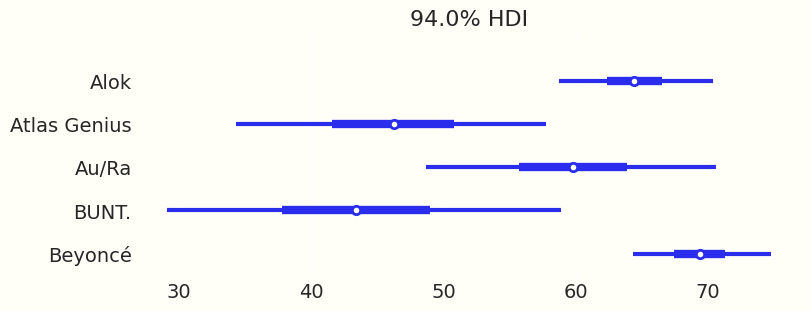

In [53]:
# We use the forest plot of arviz to display the HDI of different artists.
# The HDIs are shorter for artists that have published more songs.
# We show only the first 5 artists: we limit and label the graph using the coords option.
axes = az.plot_forest (trace_unpooled, var_names="mu_artist",
                       combined=True, # a single plot for each artist,  merging  samples from different chains.
                       coords={"mu_artist_dim_0": range(5)}, figsize=(8, 3))
artists_5 = artists[:5]
axes[0].set_yticklabels(artists_5[::-1]);

In [54]:
# the global_sigma represents the variations between songs produced by the same artist.
# It is the same for every artist.
# The posterior value of about 14 means that songs from the artist j might range in +- 28 (2 sigma)
# around mu_j, a pretty large range. In the pooled model, the posterior mean of sigma was about 20.
az.summary(trace_unpooled, var_names='sigma_songs')


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_songs,13.966,0.529,12.967,14.895,0.01,0.012,2805.0,1654.0,1.0


# Predictive distribution for the next song of Beyoncé

* For each  posterior samples $<\mu_{\text{Beyoncé},s}, \sigma_s>$:
    * sample $y_{\text{Beyoncé},s}^{\text{new}}$ from a normal distribution.

$$
\left[
\begin{array}{ll}
\mu_{\text{Beyoncé},1} &   \sigma_{\text{songs}, 1} \\
\mu_{\text{Beyoncé},2}  & \sigma_{\text{songs}, 2} \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{\text{songs}, 4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

# Predictive distribution of Beyoncé and BUNT in Pymc

In [55]:
#predictive distribution for the next song of Beyoncé in Pymc3

with pm.Model() as unpooled_model_with_preds:

    #lines below as in the unpooled model
    mu_artist       =  pm.Normal ('mu_artist', 50,  20, shape= n_artist)
    sigma_songs     =  pm.HalfNormal ('sigma_songs', sigma = 36)
    popularity      =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_songs, observed = spotify["popularity"])

    #predictive distribution of Beyonce and Bunt
    pred_beyonce   = pm.Normal ('pred_beyonce', mu = mu_artist[beyonce_code],  sigma = sigma_songs)
    pred_bunt   = pm.Normal ('pred_bunt', mu = mu_artist[bunt_code],  sigma = sigma_songs)

    trace_unpooled_with_preds  = pm.sample()

Output()

In [56]:
# Predictive distribution of Beyonce and Bunt
#There is larger uncertainty in the  predictive distribution than
# in the posterior mean

# Moreover, there is more uncertainty (see the sd) for  Bunt than for Beyoncè.
az.summary(trace_unpooled_with_preds, var_names=['pred_bunt','pred_beyonce'], hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_bunt,43.537,15.843,14.132,75.386,0.301,0.341,2775.0,1583.0,1.0
pred_beyonce,69.490,14.119,44.861,98.969,0.200,0.356,4968.0,1325.0,1.0


In [57]:
# For a given artist, notice the difference between the posterior predictive distribution  (above)
# and the posterior distribution of the mean (below).
# The posterior mean is  narrower than the predictive, as it does not account for the variability between songs.

trace_unpooled_with_preds = trace_unpooled_with_preds.assign_coords(mu_artist_dim_0=artists)
az.summary(trace_unpooled_with_preds).head()[3:5]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_artist[BUNT.],43.416,7.483,29.865,58.204,0.141,0.167,2775.0,1351.0,1.0
mu_artist[Beyoncé],69.331,2.681,64.371,74.588,0.039,0.069,4816.0,1335.0,1.0


# Shortcoming of the unpooled model


* The estimate of the posterior for artists with few songs are  uncertain - see Bunt.

    
* it  does not model the *population* of  artists. Even though we have analyzed 44 artist, we are unable to say anything about another  Spotify artist not  present in our data set.

# Hierarchical model

\begin{equation}
\begin{array}{lrl}
& \mu_{\text{pop}} & \sim N(\mu_{\text{hier}}, \sigma_{\text{hier}}) \;\;\;
\text{prior  about mean popularity of the different artists of the population} \\
& \sigma_{\text{pop}} & \sim HN(\xi_{hier})  \;\;\;
 \text{prior  about std of artist popularity in the population} \\
 \\
 & \mu_j & \sim N( \mu_{\text{pop}}, \sigma_{\text{pop}})  \;\;\;  \text{ $\mu_j$ is a sample from the population of artists}\\
 & \sigma_{\text{songs}} & \sim HN(\xi)  \;\;\; \text{same prior of the unpooled model }  \\
\\
 & y_{ij} & \sim N( \mu_j, \sigma) \;\;\;  \hspace{-0.075in} \text{distrib of  popularity of the songs of artist } j
\\
\end{array}
\end{equation}

* There is a prior over the parameters of the prior of $\mu_j$, which which are instead fixed numbers in the unpooled model.

* Those prior allow learning the mean and standard deviation of the population of artists.

# Individual songs for each artist.

* As in the unpooled model,  the popularity of songs  of  artist $j$ are distributed:

$$  y_{ij} \sim N(\mu_j, \sigma_{\text{songs}}) $$

* $\mu_j$: mean popularity of the songs by artist $j$



# Modeling the population of artists

$$ \mu_j \sim N(\mu_{\text{pop}}, \sigma_{\text{pop}}) $$


* We want to learn the population of artists.
  
* Both $\mu_{\text{pop}}$ and $\sigma_{\text{pop}}$ are  *parameters*, to which we will assign a prior.

# Recap

* $\mu_{\text{pop}}$: mean popularity of the artists, within the population of artists


* $\sigma_{\text{pop}}$ standard deviation of the popularity of the artists, i.e., of the  $\mu_j$.


*  $\mu_j$: popularity of artist $j$, i.e.,  mean popularity of songs from the artist $j$.  

* $\sigma_{\text{songs}}$:  standard deviation of popularity between songs from the same author.


# Priors for  $\mu_{\text{pop}}$ and  $\sigma_{\text{pop}}$

\begin{align*}
\mu_{\text{pop}}    & \sim N(50, 10) && \text{the population mean is comprised within prob 0.95 in 30 - 70} \\
\sigma_{\text{pop}} & \sim \text{Half Normal}(10)    && \text{same as the unpooled model: spread of the } \mu_j\\
\end{align*}

* The prior on $\mu_{\text{pop}}$ represent where we think the mean popularity of the artist to be. We can keep the same prior of the unpooled model.

* The scale of the halfnorm represent how the $\mu_j$ are spread; we aim at having a range of 10-90.

# The resulting hierarhical model

\begin{equation}
\begin{array}{lrl}
& \mu_{\text{pop}} & \sim N(50, 10) \;\;\; \\
& \sigma_{\text{pop}} & \sim HN(15)  \;\;\; \\
 \\
 & \mu_j & \sim N( \mu_{\text{pop}}, \sigma_{\text{pop}})  \;\;\;  \text{ $\mu_j$ is a sample from the population of artists}\\
 & \sigma_{\text{songs}} & \sim HN(10)  \;\;\; \text{as in the unpooled model }  \\
\\
 & y_{ij} & \sim N( \mu_j, \sigma_{\text{songs}}) \;\;\;  \hspace{-0.075in}
\\
\end{array}
\end{equation}

* The prior $\sigma_{\text{pop}}  \sim HN(15)$ has been set guessing; a better solution would have been a prior predictive check.

In [67]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:

    # prior on the parameters of the population of artists (hyper-priors).

    # prior beliefs about the mean value and the spread of the different mu_j
    #This is where the hierarchical model differs from the unpooled model.
    mu_pop     = pm.Normal ('mu_pop', 50,  10)
    sigma_pop  = pm.HalfNormal ('sigma_pop', 15)


    # layer 2: each artist is a sample from the population of artists; we sample n_artist times from such population.
    mu_artist   =  pm.Normal ('mu_artist', mu=mu_pop, sigma=sigma_pop, shape= n_artist)

    # spread between songs of the same authors) is as in the unpooled model.
    sigma_songs  =  pm.HalfNormal ('sigma_songs', sigma = 10)

    #Popularity of each song is a sample from N(mu_j, sigma_songs).
    popularity   =  pm.Normal ('popularity', mu = mu_artist[spotify['artist_code']],  sigma = sigma_songs, observed = spotify["popularity"])

    #predictive distribution of Beyoncè
    #this is not needed to fit the model. It is useful however to illustrate
    #the difference between unpoled and hierarchical model.
    #This line of code is identical to that of the unpooled model.
    pred_beyonce   = pm.Normal ('pred_beyonce', mu = mu_artist[beyonce_code],  sigma = sigma_songs)
    pred_bunt   = pm.Normal ('pred_bunt', mu = mu_artist[bunt_code],  sigma = sigma_songs)



    trace_hier   = pm.sample(return_inferencedata=True)

Output()

/usr/local/lib/python3.12/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (49) in plot_posterior, generating only 40 plots
  warnings.warn(


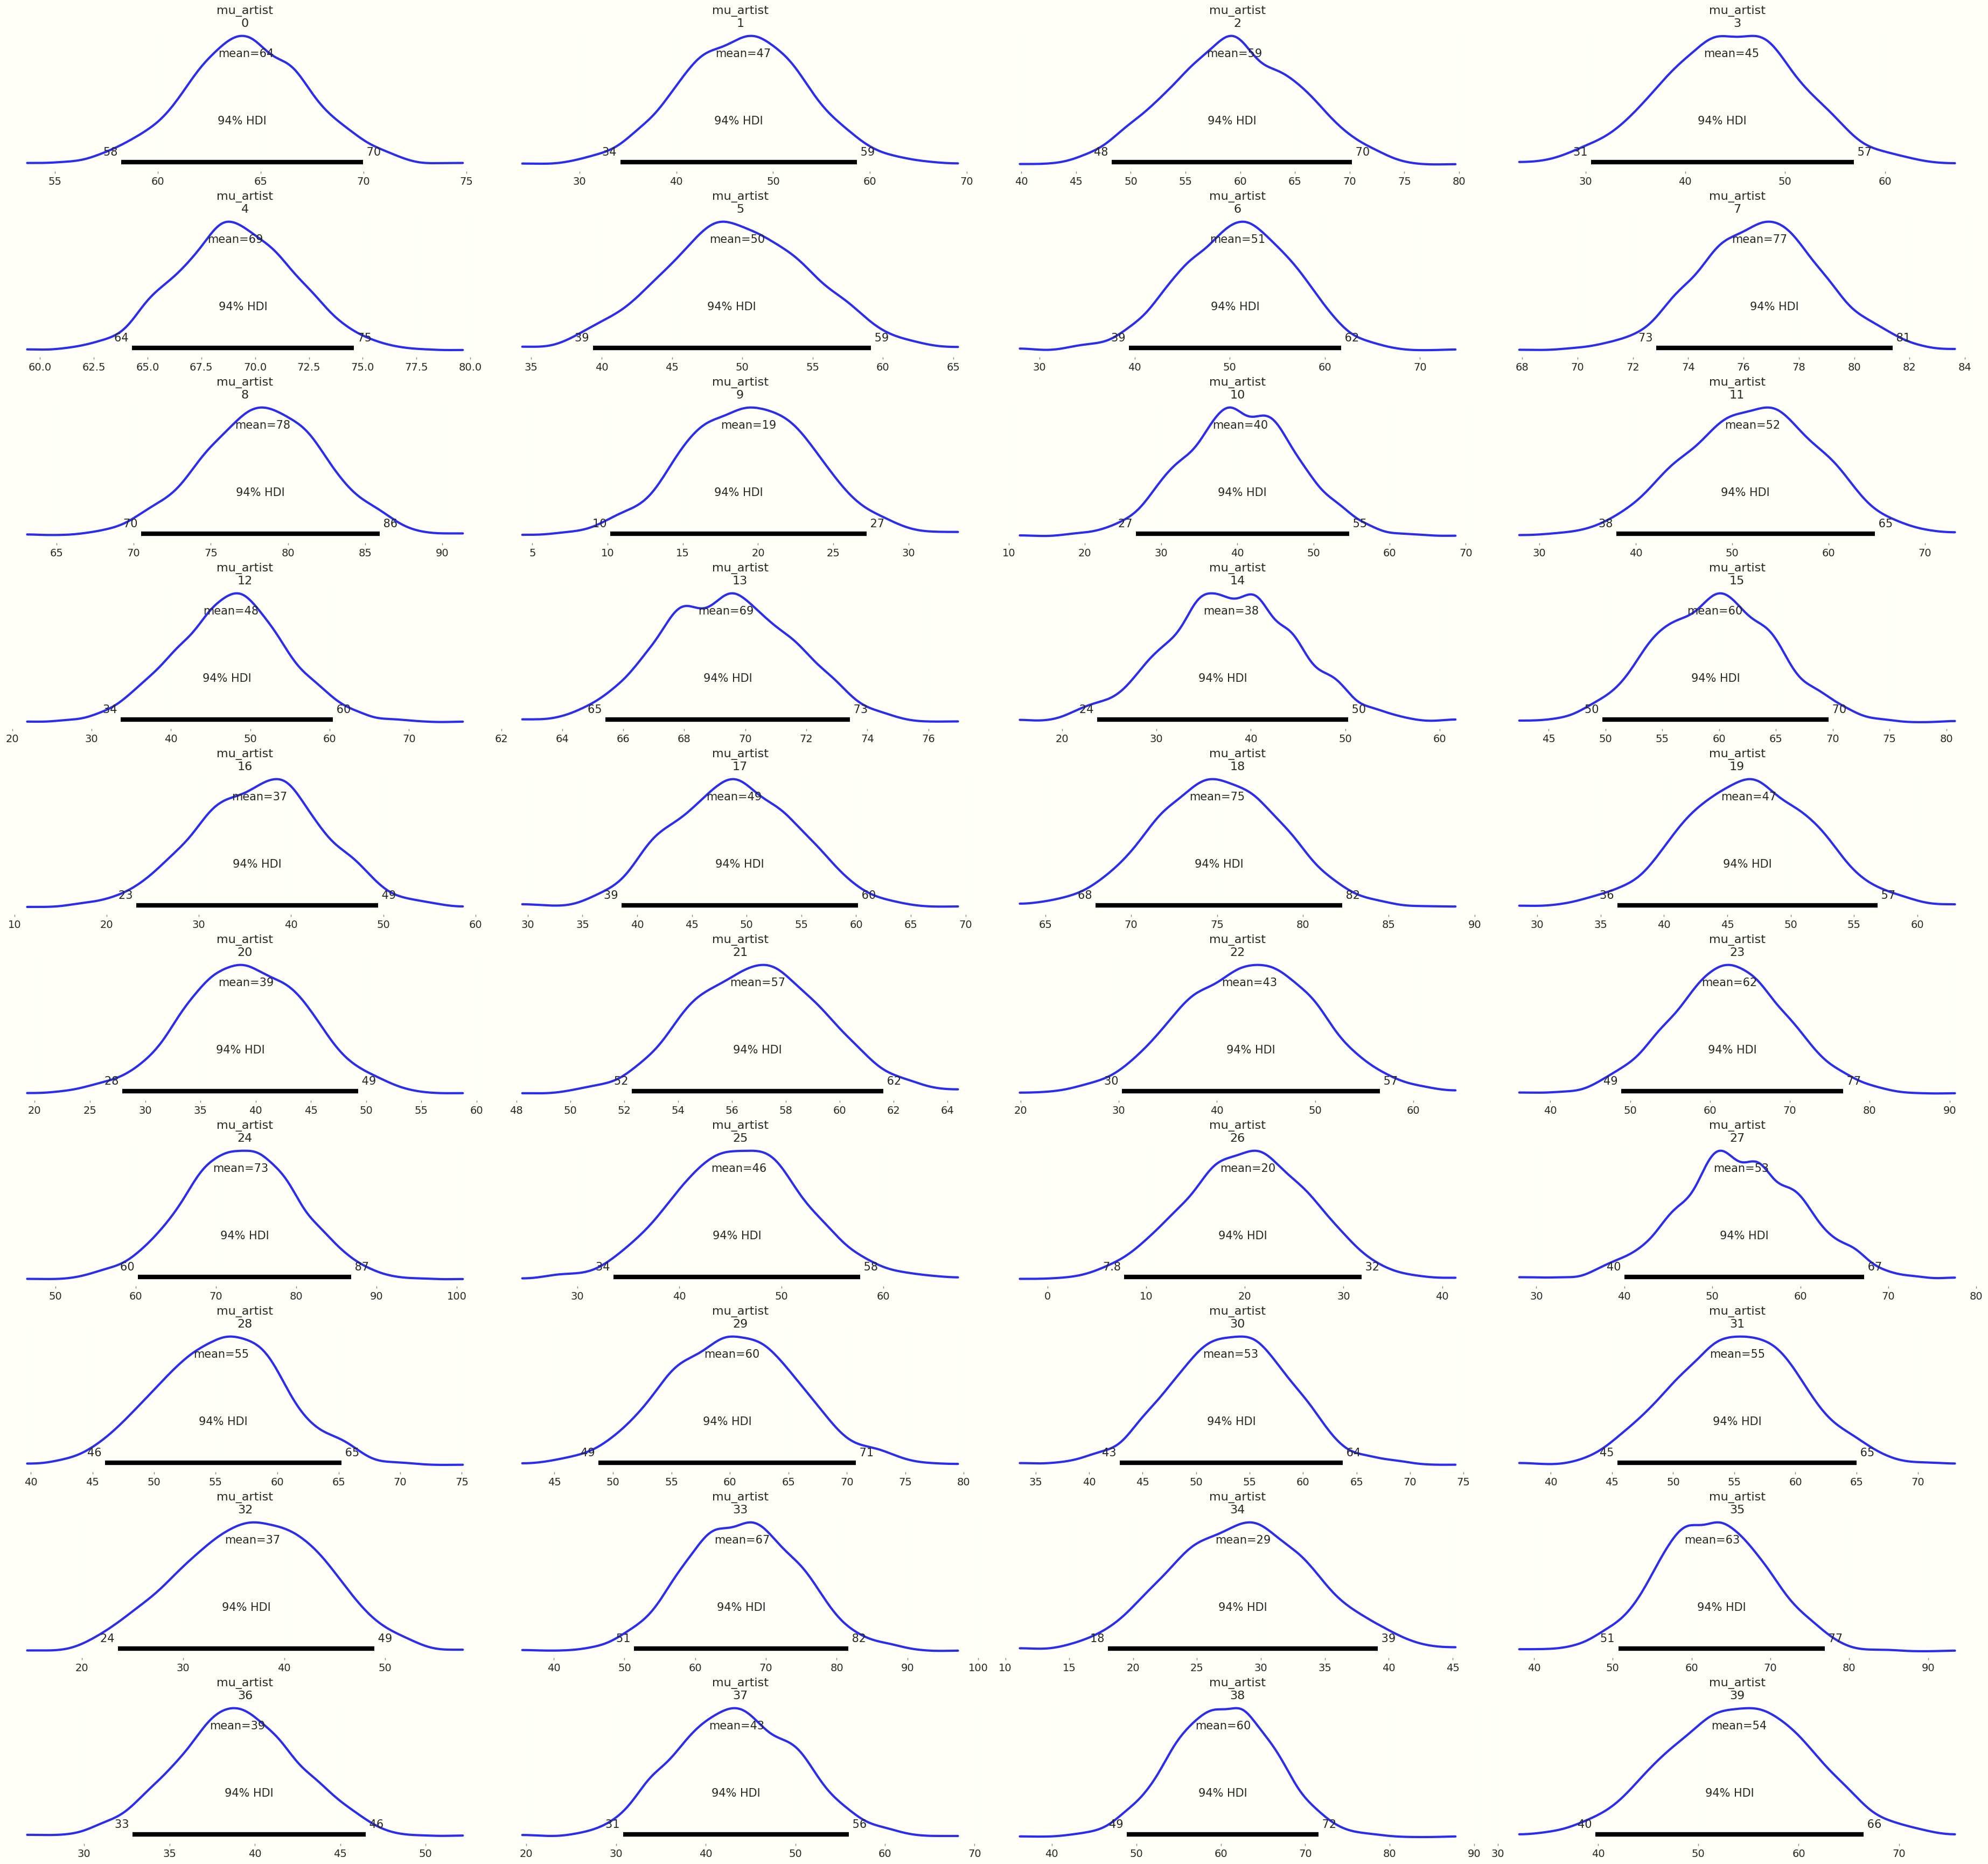

In [59]:
az.plot_posterior(trace_hier);

In [60]:
#mu_pop is indeed close to 50 as we assumed
#the 95% popularity of the artists varies in roughly 52 +- 30
#the songs of a given author are comprised with 95% probability within a range of +-28 around its mean.
az.summary(trace_hier, var_names=["mu_pop", "sigma_pop", "sigma_songs", "mu_artist"])[["mean","hdi_3%","hdi_97%","r_hat"]].head()

,mean,hdi_3%,hdi_97%,r_hat
mu_pop,52.311,47.788,56.782,1.0
sigma_pop,15.057,11.687,18.677,1.0
sigma_songs,13.994,12.942,15.110,1.0
mu_artist[0],64.282,58.201,69.968,1.0
mu_artist[1],46.916,34.211,58.664,1.0


# Comparing the mnean estimates of the hierarchical model and the unpooled model

* The hierarchical model brings the estimates of the individual artists closer to the global mean (mean of the unpooled model)

* Thus, it slightly decreases the score of the highest-scoring artists and
increases those of the lowest-scoring ones.

* This is called *shrinkage*. You can think of shrinkage as a kind of regularization.

* The underlying stastistical reason is that the model bring the extreme estimates towards values which are more central and thus more plausibile according to the distribution of the population.

In [68]:
# The hierarchcical slightly decreases the estimate for Beyonce and slightly increases that of BUNT.
hier_pred_summary=az.summary(trace_hier, var_names=["pred_beyonce", "pred_bunt"])
unpooled_pred_summary=az.summary(trace_unpooled_with_preds, var_names=["pred_beyonce", "pred_bunt"])
pd.concat([hier_pred_summary, unpooled_pred_summary])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pred_beyonce,69.176,13.967,43.358,95.187,0.212,0.337,4357.0,1363.0,1.0
pred_bunt,44.576,15.892,16.028,75.187,0.285,0.320,3099.0,1728.0,1.0
pred_beyonce,69.490,14.119,44.554,96.445,0.200,0.356,4968.0,1325.0,1.0
pred_bunt,43.537,15.843,14.132,73.397,0.301,0.341,2775.0,1583.0,1.0


In [72]:
# preparing the traces, to be able to access using names.
#this way the name of the artist is assigned to each mu_j
#the trace object has an internal field called mu_artist_dim_0
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(mu_artist_dim_0=artists)
trace_hier.posterior = trace_hier.posterior.assign_coords(mu_artist_dim_0=artists)

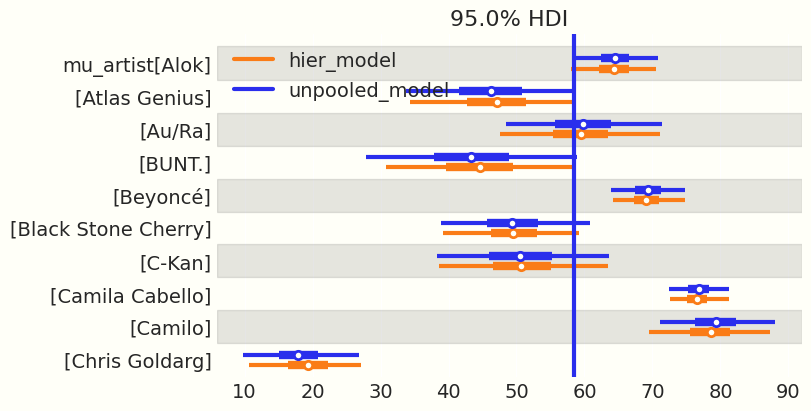

In [73]:
#estimated mean popularity of each artist, according to the unpooled and to the hierarhical model
# the expected values of the hierarchical model are pulled towards to general mean (shrinkage).
axes = az.plot_forest([trace_unpooled, trace_hier],
                      model_names=['unpooled_model', 'hier_model'], combined=True,
                      var_names='mu_artist', hdi_prob=0.95, coords={"mu_artist_dim_0": artists[0:10]},  figsize=(8, 4));
#mean popularity of all songs
grand_mean = spotify["popularity"].mean()
axes[0].axvline(x=grand_mean);

# The hierarchical model pulls the estimates towards the grand mean

*  The pooled  model ignores the fact that our data is grouped by artist.


*  The unpooled model separately analyzes each artist ignoring the information about the grand mean.


* The hierarchical model pulls  the estimates of the unpooled model  towards the grand mean (*shrinkage*).


# Shrinkage

* Given $\sigma_{\text{songs}}^2$ and  $\sigma^2_{\text{pop}}$, the posterior mean of the hierarchical model for  artist $j$  is a compromise between the posterior mean of the pooled and the unpooled model:

$$
\overline{\mu}_{j,\text{hier}} =
\underbrace{
\frac{\sigma_{\text{songs}}^2}{\sigma_{\text{songs}}^2 + n_j \sigma^2_{\text{pop}}}
}_{\text{weight of the grand mean}}
\overline{\mu}_{\text{pooled}} +
\underbrace{
\frac{n_j\sigma^2_{\text{pop}}}{\sigma_{\text{songs}}^2+ n_j \sigma^2_{\text{pop}}}
}_{\text{weight of the estimate of the unpooled model}}
\overline{\mu}_{j, \text{unpooled}}
$$

* $\overline{\mu}_{\text{pooled}}$: posterior mean of the pooled model.

* $\overline{\mu}_{\text{unpooled}}$: posterior mean of the unpooled model.

* If $n_j$ is small:  $$\overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{\text{pooled}}$$

* If $n_j$ is large:  $$\overline{\mu}_{j,\text{hier}}  \approx \overline{\mu}_{j, \text{unpooled}}$$


# Shrinkage


* The behavior of the model is in reality more complex as  variances and means are parameters.


* Hence a different weighted sum is computed  for each posterior sample of the trace.

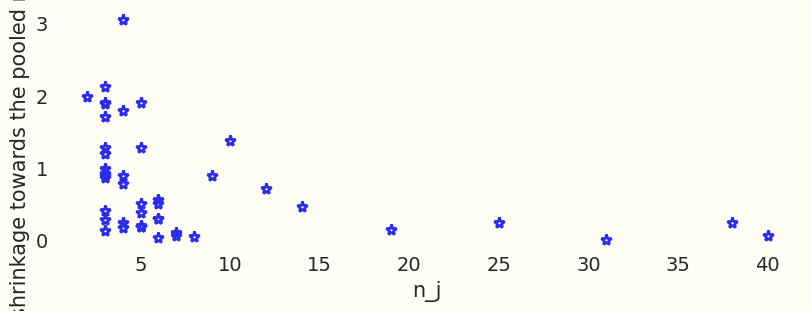

In [74]:
# here we define shrinkage as the difference between the posterior mean of the hierarchical model
# and the unpooled model, in absolute value.
# For artists with less than 10 songs, the mean popularity can be shrunk up to 2-3 points towards the pooled mean.

n_j = spotify['artist'].value_counts(sort=False)
mean_unpooled = az.summary(trace_unpooled, var_names=["mu_artist"])["mean"]
mean_hier = az.summary(trace_hier, var_names=["mu_artist"])["mean"]

#absolute value of the shrinkage
shrinkage = pd.Series((mean_hier-mean_unpooled).values, index=artists).abs()

df = pd.concat([n_j, shrinkage], axis=1)
df.columns = ["n_j", "shrinkage"]
plt.plot(df["n_j"], df["shrinkage"], "*")
plt.xlabel("n_j")
plt.ylabel("shrinkage towards the pooled mean");

# Predictive distribution for the next song of a known artist

$$
\left[
\begin{array}{ll}
\mu_{\text{Beyoncé},1} &   \sigma_{\text{songs}, 1} \\
\mu_{\text{Beyoncé},2}  & \sigma_{\text{songs}, 2} \\
\vdots & \vdots  \\
\mu_{\text{Beyoncé},4000}   & \sigma_{\text{songs}, 4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{Beyoncé},1}^{\text{new}} \\
y_{\text{Beyoncé},2}^{\text{new}}\\
\vdots \\
y_{\text{Beyoncé},4000}^{\text{new}}\\
\end{array}
\right]
$$

* This works in the same way of the unpooled model,  with the difference that the values of $\mu_{\text{Beyoncé}}$ will be (slightly) pulled towards the general mean.

# Predictive distribution of the hierarchical model: the first song of a new artist

* It requires two sampling steps.


* First we sample possible values of $\mu_{\text{new a}}$ of the new artist from the population of artists; "new a" stands for new artist.


* Given the samples of $\mu_{\text{new a}}$, we follow the same procedure of the  artists with songs.



# Predictive distribution for the first song artist of a new artist

* Requires two steps of sampling.

* We create samples for $\mu_{\text{new a}}$ for the new artist by using the  posterior samples of $\mu'$ and $\sigma_{\mu}$, i.e., by sampling from the population of artists.

$$
\left[
\begin{array}{ll}
\mu_{\text{pop},1} &   \sigma_{\text{pop},1} \\
\mu_{\text{pop},2}  & \sigma_{\text{pop},2} \\
\vdots & \vdots  \\
\mu_{\text{pop},4000}   & \sigma_{\text{pop},4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
\mu_{\text{new a},1} \\
\mu_{\text{new a},2}\\
\vdots \\
\mu_{\text{new a},4000}\\
\end{array}
\right]
$$

# Predictive distribution for the next song of a  **known** artist

* For each posterior sample  $<\mu_{\text{new a},s}, \sigma_s>$, draw a value from $N(\mu_{\text{new a},s}, \sigma_s)$.

$$
\left[
\begin{array}{ll}
\mu_{\text{new a},1} &   \sigma_{\text{songs}, 1} \\
\mu_{\text{new a},2}  & \sigma_{\text{songs}, 2} \\
\vdots & \vdots  \\
\mu_{\text{new a},4000}   & \sigma_{\text{songs}, 4000} \\
\end{array}
\right]
\;\; \longrightarrow \;\;
\left[
\begin{array}{l}
y_{\text{new a},1} \\
y_{\text{new a},2}\\
\vdots \\
y_{\text{new a},4000}\\
\end{array}
\right]
$$

# Your turn

* Working on the raw samples from the trace, compute:

    * the predictive distribution for the next song of Beyonce and BUNT using  the hierarchical and the unpooled model; comment the results.

    * the predictive distribution for the first song of a a new artist using to the hierarchical model.

    * hint:  use `beyonce_code` as index  for the position Beyonce within mu_artist



# Your turn - 2

* Alicia  invites four friends to  take 20 speed-typing tests of equal difficulty. Let $y_{ij}$ be the time it takes friend $j$ to complete test $i$.

* Define a hierarchical model and discuss the meaning of its equations.
    
* Assume that each person is  consistent in his typing times, but there are big differences from person to person.

    * Is  $ \sigma_{tests}$  lower, larger or close to $\sigma_{pop}$?


# Grouping variable or covariate?

* Consider a categorical variable  $X$.


* Should $X$  be modeled  hierarchically  or  treated as a categorical variable (unpooled model)?

    *   if the data covers all categories,  it is better treated as a categorical variable
    
    *  if the observed categories are only a  sample from many possible ones,  the hierarchical approach is recommended.


# Grouping variable or covariate?


* Our data set includes only  44 among thousands of artists on Spotify. Treating artist as a categorical variable (unpooled model) would limit our conclusions  to  this small sample.


* Treating it as a grouping variable (hierarchical model) allows us to learn about the  broader population of artists from which they were sampled.


# Grouping variable or covariate?

* A daily data set of bike-sharing covers two years;  we know whether each day  was a weekday or a weekend.

* The dataset covers both categories, with many observations for each category.

* Hence  it is better treated as a categorical variable (unpooled model).

# Grouping variable or covariate?

* Consider a data set containing math scores  from of 10  Swiss primary schools; this is a  small sample from the hundreds  of schools.


* The unpooled model  learns only about this small sample of schools.


* The hierarchical model   extends its conclusions to the  population of all schools; this is a better modelling choice.
    
    
* The same consideration applies if you want to analyze e.g. data of a certain disease collected by different hospitals.

# Solutions

In [65]:
#prediction for Beyonce using the unpooled and the hierarchical model
post_hier         = az.extract(trace_hier.posterior)
mu_beyonce_hier   = post_hier.mu_artist[beyonce_code].values
sigma_songs_hier  = post_hier.sigma_songs.values

post_unpooled     = az.extract(trace_unpooled.posterior)
mu_beyonce_unpooled  = post_unpooled.mu_artist[beyonce_code].values
sigma_songs_unpooled = post_unpooled.sigma_songs.values

y_beyonce_hier     = np.zeros(len(mu_beyonce_hier))
y_beyonce_unpooled = np.zeros(len(mu_beyonce_hier))

for i, current_mu in enumerate(mu_beyonce_hier):
        y_beyonce_hier[i]     = np.random.normal (loc = mu_beyonce_hier[i], scale = sigma_songs_hier[i])
        y_beyonce_unpooled[i] = np.random.normal (loc = mu_beyonce_unpooled[i], scale = sigma_songs_unpooled[i])

#the predictions of the hierarchical model are slightly lower and pulled towards the mean of the pooled model.
#yet the difference is small since there are many songs from Beyonce.
print('hier: ')
print(pd.DataFrame(y_beyonce_hier).describe(percentiles=[0.025, 0.975]))
print('\n\n')

print('unpooled:')
print(pd.DataFrame(y_beyonce_unpooled).describe(percentiles=[0.025, 0.975]))

hier: 
                 0
count  2000.000000
mean     69.064608
std      14.045130
min      21.262770
2.5%     41.247709
50%      69.383519
97.5%    95.442071
max     123.499617



unpooled:
                 0
count  2000.000000
mean     69.678306
std      14.539114
min      18.049101
2.5%     40.213036
50%      69.501160
97.5%    98.620052
max     111.671287


In [66]:
#prediction for a novel artist
post_hier   = az.extract(trace_hier.posterior)

#posterior parameters of the population
mu_population    = post_hier.mu_pop.values
sigma_population = post_hier.sigma_pop.values

mu_new_artist  = np.zeros(len(mu_population))

for i, current_mu in enumerate(mu_population):
        mu_new_artist[i] = np.random.normal (loc = mu_population[i], scale = sigma_population[i])

#now we have the distribution for the mean of the novel artist.
#we thus compute the distribution for its next song
sigma_songs = post_hier.sigma_songs.values
popularity_new_song_new_artist  = np.zeros(len(sigma_songs))

for i, current_mu in enumerate(mu_population):
        popularity_new_song_new_artist[i] = np.random.normal (loc = mu_new_artist[i], scale = sigma_songs[i])

#we obtain a  large predictive distribution, whose 95% hdi varies between 9.8 and 94.
#there is a major increase in the std wrt a known artist such as Beyonce.
pd.DataFrame(popularity_new_song_new_artist).describe(percentiles=[0.025, 0.975])

,0
count,2000.000000
mean,52.606509
std,20.864015
min,-21.895543
2.5%,12.510408
50%,52.833689
97.5%,93.585149
max,120.535771
